#Libraries and Data

In [2]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
#load the datast
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "IOC"
data = yfinance.download (tickers = "{}.NS".format(stock_name),start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-06-22,18853.599609,18886.599609,18759.500000,18771.250000,252700
2023-06-23,18741.849609,18756.400391,18647.099609,18665.500000,210600
2023-06-26,18682.349609,18722.050781,18646.699219,18691.199219,171300
2023-06-27,18748.550781,18829.250000,18714.250000,18817.400391,222500
2023-06-30,19076.849609,19201.699219,19024.599609,19189.050781,247900


#Data preparation

In [4]:
#transform the date variable
data["Data"] = pd.to_datetime(data.index, format = "%m/%d/%Y")
data.Data

Date
2007-09-17   2007-09-17
2007-09-18   2007-09-18
2007-09-19   2007-09-19
2007-09-20   2007-09-20
2007-09-21   2007-09-21
                ...    
2023-06-22   2023-06-22
2023-06-23   2023-06-23
2023-06-26   2023-06-26
2023-06-27   2023-06-27
2023-06-30   2023-06-30
Name: Data, Length: 3868, dtype: datetime64[ns]

In [7]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Data': 'ds'})
data.tail(10)

,High,Low,y,Volume,ds
Date,,,,,
2023-06-15,18794.099609,18669.050781,18688.099609,263000,2023-06-15
2023-06-16,18864.699219,18710.500000,18826.000000,272800,2023-06-16
2023-06-19,18881.449219,18719.150391,18755.449219,219800,2023-06-19
2023-06-20,18839.699219,18660.650391,18816.699219,211600,2023-06-20
2023-06-21,18875.900391,18794.849609,18856.849609,217500,2023-06-21
2023-06-22,18886.599609,18759.500000,18771.250000,252700,2023-06-22
2023-06-23,18756.400391,18647.099609,18665.500000,210600,2023-06-23
2023-06-26,18722.050781,18646.699219,18691.199219,171300,2023-06-26
2023-06-27,18829.250000,18714.250000,18817.400391,222500,2023-06-27


#Holidays

In [6]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [7]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [8]:
#create training and test set
test_days = 2000
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [9]:
 training_set.tail(1)
#test_set.tail(1)

,High,Low,y,Volume,ds
Date,,,,,
2015-05-18,8384.599609,8271.950195,8373.650391,148700,2015-05-18


#Prophet

In [10]:
m = Prophet(
            #holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 20,
            changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)


21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
mFullData = Prophet(
            #holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 20,
            changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
mFullData.fit(data)

21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing


In [43]:

# Save the trained model to a file
with open('./TrainedModel/prophet/{}prophet_model_2.pkl'.format(stock_name), 'wb') as f:
    pickle.dump(mFullData, f)

In [13]:
#create future df
future = m.make_future_dataframe(periods = test_days,
                                 freq = "B")

#create future df
future_full = mFullData.make_future_dataframe(periods = 0,
                                 freq = "B")

In [14]:
future_full.tail(1)

,ds
3867,2023-06-30


In [16]:
future = pd.concat([future], axis = 1)
future_full = pd.concat([future_full], axis = 1)

 

In [17]:
future_full

,ds
0,2007-09-17
1,2007-09-18
2,2007-09-19
3,2007-09-20
4,2007-09-21
...,...
3863,2023-06-22
3864,2023-06-23
3865,2023-06-26
3866,2023-06-27


In [18]:
#forecast
forecast = m.predict(future)
forecast.tail()
#forecast full data
forecast_full = mFullData.predict(future_full)
forecast_full.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
3863,2023-06-22,5090.792723,18418.730296,20062.137670,5090.792723,5090.792723,2.781186,2.781186,2.781186,2.888963,2.888963,2.888963,-0.107777,-0.107777,-0.107777,0.0,0.0,0.0,19249.235357
3864,2023-06-23,5092.643363,18364.855926,20078.402975,5092.643363,5092.643363,2.773877,2.773877,2.773877,2.881312,2.881312,2.881312,-0.107435,-0.107435,-0.107435,0.0,0.0,0.0,19219.008174
3865,2023-06-26,5098.195282,18464.021553,20121.367650,5098.195282,5098.195282,2.783920,2.783920,2.783920,2.887562,2.887562,2.887562,-0.103642,-0.103642,-0.103642,0.0,0.0,0.0,19291.162272
3866,2023-06-27,5100.045922,18507.633314,20184.564952,5100.045922,5100.045922,2.789532,2.789532,2.789532,2.890988,2.890988,2.890988,-0.101456,-0.101456,-0.101456,0.0,0.0,0.0,19326.786544
3867,2023-06-30,5105.597841,18491.017437,20159.117890,5105.597841,5105.597841,2.788936,2.788936,2.788936,2.881312,2.881312,2.881312,-0.092375,-0.092375,-0.092375,0.0,0.0,0.0,19344.785885


In [20]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data

,index,Date,High,Low,y,Volume,ds
0,0,2007-09-17,4549.049805,4482.850098,4494.649902,0,2007-09-17
1,1,2007-09-18,4551.799805,4481.549805,4546.200195,0,2007-09-18
2,2,2007-09-19,4739.000000,4550.250000,4732.350098,0,2007-09-19
3,3,2007-09-20,4760.850098,4721.149902,4747.549805,0,2007-09-20
4,4,2007-09-21,4855.700195,4733.700195,4837.549805,0,2007-09-21
...,...,...,...,...,...,...,...
3863,3863,2023-06-22,18886.599609,18759.500000,18771.250000,252700,2023-06-22
3864,3864,2023-06-23,18756.400391,18647.099609,18665.500000,210600,2023-06-23
3865,3865,2023-06-26,18722.050781,18646.699219,18691.199219,171300,2023-06-26
3866,3866,2023-06-27,18829.250000,18714.250000,18817.400391,222500,2023-06-27


In [21]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.tail(1)
prophet_variables_full = forecast_full.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb_full = pd.concat([data, prophet_variables_full], axis = 1)
#df_xgb_full.tail(1)
df_xgb_full.tail(1)


,index,Date,High,Low,y,Volume,ds,trend,weekly,multiplicative_terms
3867,3867,2023-06-30,19201.699219,19024.599609,19189.050781,247900,2023-06-30,5105.597841,2.881312,2.788936


#XGBoost preparation

In [22]:
#create training and test set
test_days = 100
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [23]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]
#full data 
y_train_full = df_xgb_full.y
x_train_full = df_xgb_full.iloc[:, 2:]


In [24]:
x_train_full = x_train_full.drop(columns=["ds"])
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])
#x_train_full = x_train_full.drop(columns=["ds"])

In [25]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [26]:
#Matrices FULL DATA
Train_full = xgb.DMatrix(x_train_full, label = y_train_full)


In [27]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [28]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:12706.58606
[1]	y-rmse:9050.93816
[2]	y-rmse:6433.38033
[3]	y-rmse:4573.01366
[4]	y-rmse:3268.33152
[5]	y-rmse:2348.14724
[6]	y-rmse:1682.46698
[7]	y-rmse:1206.06264
[8]	y-rmse:885.50291
[9]	y-rmse:643.24272
[10]	y-rmse:473.46735
[11]	y-rmse:350.66466
[12]	y-rmse:262.99619
[13]	y-rmse:202.71173
[14]	y-rmse:161.43628
[15]	y-rmse:129.67498
[16]	y-rmse:107.89093
[17]	y-rmse:93.75269
[18]	y-rmse:83.68628
[19]	y-rmse:73.29724
[20]	y-rmse:68.62056
[21]	y-rmse:67.66431
[22]	y-rmse:63.07636
[23]	y-rmse:62.66516
[24]	y-rmse:59.86818
[25]	y-rmse:57.04855
[26]	y-rmse:53.98724
[27]	y-rmse:53.31489
[28]	y-rmse:52.06774
[29]	y-rmse:49.84053
[30]	y-rmse:49.83133
[31]	y-rmse:49.81406
[32]	y-rmse:48.93724
[33]	y-rmse:48.19706
[34]	y-rmse:48.19817
[35]	y-rmse:48.23064
[36]	y-rmse:48.19878
[37]	y-rmse:47.91716
[38]	y-rmse:47.91788
[39]	y-rmse:47.91353


In [29]:
#FULL
model_full = xgb.train(params = parameters,
                  dtrain = Train_full,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:12672.33578
[1]	y-rmse:8943.51593
[2]	y-rmse:6307.62003
[3]	y-rmse:4463.81618
[4]	y-rmse:3163.41828
[5]	y-rmse:2249.04947
[6]	y-rmse:1590.77386
[7]	y-rmse:1126.85969
[8]	y-rmse:796.25591
[9]	y-rmse:567.07536
[10]	y-rmse:402.69189
[11]	y-rmse:288.71385
[12]	y-rmse:208.67671
[13]	y-rmse:175.31306
[14]	y-rmse:136.26984
[15]	y-rmse:108.05508
[16]	y-rmse:89.74968
[17]	y-rmse:77.97516
[18]	y-rmse:67.35638
[19]	y-rmse:61.05607
[20]	y-rmse:56.86937
[21]	y-rmse:49.95308
[22]	y-rmse:48.81123
[23]	y-rmse:45.68245
[24]	y-rmse:41.59386
[25]	y-rmse:39.79493
[26]	y-rmse:38.81886
[27]	y-rmse:38.12858
[28]	y-rmse:38.02009
[29]	y-rmse:37.65977
[30]	y-rmse:37.18831
[31]	y-rmse:36.00689
[32]	y-rmse:34.52253
[33]	y-rmse:34.38510
[34]	y-rmse:34.35592
[35]	y-rmse:34.29626
[36]	y-rmse:33.65213
[37]	y-rmse:33.63189
[38]	y-rmse:33.58164
[39]	y-rmse:33.48551


In [29]:
Train_full

In [30]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

In [44]:

# Save the trained model to a file
with open('./TrainedModel/prophet/{}_prophet_model_1.pkl'.format(stock_name), 'wb') as f:
    pickle.dump(model_full, f)

In [ ]:
#f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
#f_predictions

#VIZ and assessment

In [32]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

In [33]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

<Axes: xlabel='ds'>

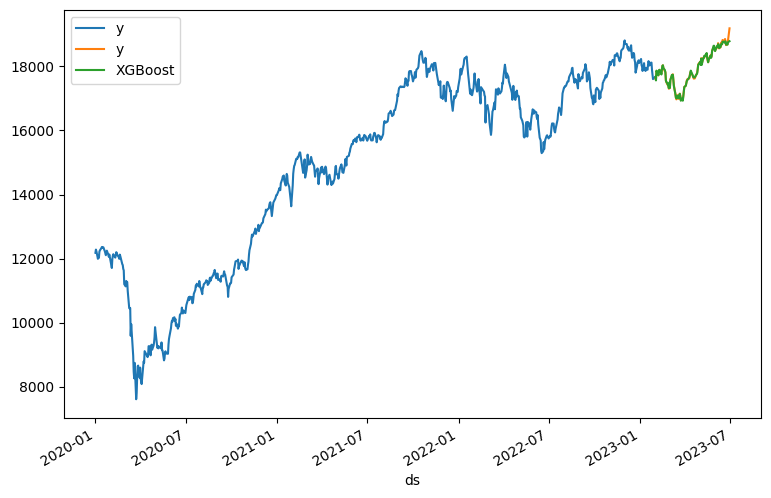

In [34]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [35]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.13186742695924672

#Future



In [36]:
# Create a dictionary with data
data = {
            'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
        'trend': [8.12313],
        'weekly': [4.123123],
            'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [37]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

0    2533.887451
Name: XGBoost, dtype: float32